# **Visualisation et statistiques descriptives**
---

## Introduction<a class="anchor" id="partie1"></a>

Ce notebook contient les codes nécessaires à la visualisation et les statistiques descriptives de notre base de données.

## Sommaire

* [Introduction](#partie1)
* [Statistiques descriptives](#partie2)
    * [Visualisation et nettoyage des données manquantes](#partie21)
    * [Statistiques descriptives intra-pays](#partie22)
        * [Résumé statistique des variables](#partie221)
        * [Étude des corrélations](#partie222)
    * [Statistiques descriptives inter-pays](#partie23)
    * [Une première analyse exploratoire des séries temporelles](#partie24)
        * [Données du PIB](#partie241)
        * [Données des Working Hours](#partie242)
        * [Données des taux d'intérêt à long terme](#partie243)
        * [Données des taux d'intérêt à court terme](#partie244)
        * [Données du CPI](#partie235)
        * [Données de la croissance potentielle](#partie246)
* [Visualisation](#partie3)
    * [Données de PIB](#partie31)
    * [Données d'heures de travail](#partie32)


In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.graphics.tsaplots as tsaplots

from Codes.scrpits_visualisations import (
    tracer_evolution,
    camembert,
    comparer_periodes
)


In [2]:
# Importation des données
#df = pd.read_excel("Données_produites/base_de_données_v1.xlsx")

#Pour voir les changements avec la suppression des données manquantes intermédiaires utiliser:
df = pd.read_excel("base_de_données_v1.xlsx")


# Indexation
df = df.set_index('Unnamed: 0')



## Statistiques descriptives <a class="anchor" id="partie2"></a>

### Visualisation et nettoyage des données manquantes <a class="anchor" id="partie21"></a>

Dans une volonté de rendre compte des valeurs manquantes à notre dataframe nous créons un dataframe qui comprend l'ensemble des valeurs manquantes 

In [ ]:
df_missing_binary = df.isnull().astype(int)
df_missing_binary

In [ ]:
df_nan = df.isna()
df_nan = pd.DataFrame({
    "TIME_PERIOD_WITH_NAN": df_nan.apply(lambda col: list(df.index[col]), axis = 0)
})
df_nan.to_csv("df_nan.csv", index=True, encoding="utf-8")
print(df_nan)

In [ ]:
# Définir la figure avec un affichage interactif
fig, ax = plt.subplots(figsize=(50, 80))

# Utiliser seaborn pour une meilleure visualisation sans grille
sns.heatmap(df_missing_binary, cmap="OrRd", cbar=False, linewidths=0, ax=ax, square=False)

# Ajouter un titre
ax.set_title("Matrice des valeurs manquantes (Rouge = Manquant)")

# Rotation des labels pour une meilleure lisibilité
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Afficher la figure
plt.show()

In [ ]:
#Pourcentage de données manquantes par variable
percentage_missing=((df_missing_binary.sum())/df_missing_binary.shape[0])*100

#On ne garde que les colonnes ayant des missing values
percentage_missing=percentage_missing[percentage_missing>0]
percentage_missing = percentage_missing.sort_values(ascending=False)

'''
Nous avons un problème avec l'Estonie, 85% des données pour les taux d'intérêt sont des valeurs manquantes
J'ai revérifié sur le site de l'OCDE et c'est un problème qui vient de leur bases de données. Comme c'est une 
un pourcentage considérable, on devrait peut-être retirer l'Estonie de notre analyse

Pour les données qui sont "entrecoupées" (on dirait un chemin de la route)--> c'est les Working Hours. On peut appliquer le même 
interpolation qu'on a faite pour construire le df. 

--> Voir tentative d'interpolation dans le notebook data.ipynb
Un problème persiste avec les données qui sont au début ou à la fin de la période temporelle, il faudra envisager
une autre méthode
'''
percentage_missing


### Statistiques descriptives intra-pays <a class="anchor" id="partie22"></a>

#### Résumé statistique des variables <a class="anchor" id="partie221"></a>

Nous allons tout d'abord effectuer des statistiques descriptives par pays des variables que nous avons collectées. Afin de mieux déterminer les effets de la politique monétaire et les chocs, nous avons privilégié une analyse centrée sur les périodes suivantes: 
- Avant 2008 (1995-2007)
- Après 2008 (2008-2019)
- Post-COVID (2020-2024)

Quelques lignes de code préliminaires

In [ ]:
#Fonction qui construit un vecteur contenant le nom des variables
def variables_pays(pays):
    variable_pays=[f'CPI_{pays}',f'PIB_{pays}',f'LT_IR_{pays}',f'ST_IR_{pays}',f'WH_{pays}',f'P_Growth_{pays}']
    return(variable_pays)

In [4]:
#Création d'une copie de la base de données ayant pour index des DateTime
df_TS=df.copy()
df_TS.index = pd.PeriodIndex(df.index, freq='Q')  #conversion en PeriodIndex
df_TS.index = df_TS.index.to_timestamp() #Conversion en DateTime
print(type(df.index))

''' 
Ici je ne suis pas sûr:
- pour faire des analyses en séries temporelles, il faut que les index soient des datetime
- j'ai donc converti chaque trimestre en la première date de chaque trimestre. 
- pour des graphes, et pour transformer les sorties, on peut utiliser : df.index.strftime('%Y-Q%q')
- je ne sais pas s'il y a une meileure façon de faire

'''


<class 'pandas.core.indexes.base.Index'>


" \nIci je ne suis pas sûr:\n- pour faire des analyses en séries temporelles, il faut que les index soient des datetime\n- j'ai donc converti chaque trimestre en la première date de chaque trimestre. \n- pour des graphes, et pour transformer les sorties, on peut utiliser : df.index.strftime('%Y-Q%q')\n- je ne sais pas s'il y a une meileure façon de faire\n\n"

In [5]:
#On divise le df en 3 (correspondant à chaque période)
df_TS_before_2008 = df_TS.loc[df_TS.index < '2008-01-01'].copy()
df_TS_after_2008 = df_TS.loc[(df_TS.index >= '2008-01-01') & (df_TS.index<'2020-01-01')].copy()
df_TS_after_2020 = df_TS.loc[df_TS.index >= '2020-01-01'].copy()


In [27]:
#Synthèse avant 2008
df_TS_before_2008.describe()

,CPI_Austria,PIB_Austria,LT_IR_Austria,ST_IR_Austria,WH_Austria,P_Growth_Austria,CPI_Belgium,PIB_Belgium,LT_IR_Belgium,ST_IR_Belgium,...,LT_IR_Switzerland,ST_IR_Switzerland,WH_Switzerland,P_Growth_Switzerland,CPI_United_Kingdom,PIB_United_Kingdom,LT_IR_United_Kingdom,ST_IR_United_Kingdom,WH_United_Kingdom,P_Growth_United_Kingdom
count,48.000000,52.000000,52.000000,52.000000,52.000000,52.000000,48.000000,52.000000,52.000000,52.000000,...,52.000000,34.000000,48.000000,52.000000,48.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,77.677431,55422.380769,4.915120,3.381302,39.175000,0.588545,77.507639,67065.700000,4.987885,3.377841,...,3.258474,1.475143,37.341146,0.480981,74.568750,428909.325000,5.553535,5.540052,36.325000,0.652542
std,4.487121,7943.450285,1.049803,0.870063,0.765782,0.063717,5.122201,10310.457162,1.128353,0.910077,...,0.773375,1.055814,0.204503,0.124752,3.874414,92803.692986,1.271353,1.140100,0.517014,0.170744
min,71.553333,43186.600000,3.222567,2.062951,37.400000,0.465652,70.003333,53331.500000,3.250000,2.062951,...,1.944333,0.136264,37.000000,0.213238,68.100000,248722.500000,4.182400,3.569803,35.100000,0.243172
25%,73.363333,48478.100000,4.152508,2.670813,38.575000,0.552114,72.515833,57891.700000,4.179167,2.670813,...,2.712750,0.645877,37.137500,0.422266,71.625000,367466.425000,4.658075,4.615929,36.025000,0.598589
50%,77.333333,55025.000000,4.818650,3.424899,39.350000,0.576752,77.433333,66230.800000,4.850000,3.359787,...,3.079500,1.270656,37.350000,0.504647,73.883333,454437.250000,5.067450,5.579657,36.500000,0.676162
75%,81.452500,60350.750000,5.558466,3.881442,39.812500,0.642478,81.423333,74390.375000,5.599167,3.855243,...,3.682750,2.279268,37.550000,0.536039,77.133333,487710.375000,5.877325,6.338393,36.600000,0.768325
max,86.650000,74092.600000,7.627367,5.043334,40.200000,0.685113,87.360000,90340.200000,8.293333,5.706666,...,5.275333,3.315616,37.600000,0.669791,82.600000,572200.400000,8.661467,7.667380,37.200000,0.836220


In [ ]:
#Synthèse après 2008
df_TS_after_2008.describe()

In [ ]:
#Synthèse après 2020
df_TS_after_2020.describe()

### Statistiques descriptives inter-pays <a class="anchor" id="partie23"></a>

#### Statistiques par types de variables <a class="anchor" id="partie231"></a>

In [29]:
# Réglages d'affichage
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)    
pd.set_option('display.width', 1000) 

##### CPI <a class="anchor" id="partie2311"></a>

In [23]:
colonnes_CPI = [colonne for colonne in df_TS.columns if colonne.startswith('CPI')]
CPI = df[colonnes_CPI]
CPI.describe()

,CPI_Austria,CPI_Belgium,CPI_Bulgaria,CPI_Czechia,CPI_Denmark,CPI_Estonia,CPI_Finland,CPI_France,CPI_Germany,CPI_Greece,...,CPI_Norway,CPI_Poland,CPI_Portugal,CPI_Romania,CPI_Slovakia,CPI_Slovenia,CPI_Spain,CPI_Sweden,CPI_Switzerland,CPI_United_Kingdom
count,116.000000,116.000000,113.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,...,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,81.000000,100.000000
mean,93.360690,93.589943,87.633392,94.581322,92.873851,88.850776,92.051638,94.097730,94.562356,91.633218,...,94.798276,91.740805,92.405259,78.268764,89.759080,88.913391,91.732902,95.888161,101.110947,86.798333
std,16.913360,16.729539,26.622093,22.115578,13.033148,28.356047,13.644561,13.138351,14.207280,15.619174,...,17.673126,23.735309,14.702079,38.872473,24.729723,21.306544,16.145513,13.970701,2.331400,13.269004
min,71.553333,70.003333,7.280000,57.300000,70.833333,44.020000,71.440000,74.483333,75.466667,59.533333,...,69.333333,43.633333,66.026667,2.760000,43.116667,44.460000,64.123333,75.716667,96.766667,68.100000
25%,78.905833,79.008333,64.406667,78.291667,82.583333,64.529167,81.339167,82.657500,82.283333,78.437500,...,81.025000,75.566667,81.594167,51.841667,73.345833,76.074167,77.935000,85.316667,100.166667,74.375000
50%,90.140000,92.233333,97.916667,92.750000,94.266667,88.021667,90.730000,94.160000,92.650000,98.780000,...,92.866667,92.683333,93.536667,87.526667,91.738333,94.231667,94.241667,96.228333,100.926667,85.016667
75%,103.470833,104.257500,102.956667,103.341667,101.066667,105.360833,101.421667,101.656667,102.341667,102.064167,...,106.191667,101.608333,102.274167,101.208333,101.103333,101.718333,101.844167,103.540833,101.533333,99.891667
max,135.183333,133.383333,138.553333,152.600000,119.733333,156.640000,120.513333,123.983333,129.900000,120.846667,...,136.333333,150.666667,123.280000,152.536667,144.826667,128.636667,124.116667,129.976667,107.750000,109.000000


On remarque que les moyennes sont assez similaires aux alentours comprises entre 91 et 95 pour la plupart des pays, on a cependant certains pays pour lesquels elles sont en dessous, avec notamment l'Islande et la Roumanie sous les 80 et la Suisse est la seule au delà des 100. On remarque aussi des écart-types plus élevées (au-dessus des 20) pour les pays d'Europe de l'Est et du Nord-est (et l'Islande), contre des écart-types compris entre 13 et 17 pour la plupart des autres pays, la Suisse faisant exception avec un écart-types de 2,33. Ces différences s'expliquent par des évolutions bien plus fortes depuis les années 1995 par ces pays de l'Est. les graphes ci-dessous illustrent cela.

Concernant les valeurs présentes, il y a 116 périodes, soit du premier trimestre de 1996 au dernier de 2024, sauf pour la Bulgarie (113), qui semble commencer en 1997, le Royaume-Uni (100), qui s'arrête en 2021, et la Suisse (81), qui commence en 2005.

In [ ]:
tracer_evolution(CPI, xlabel ="Période",ylabel = "Indice des Prix à la consommation ")

Le graphique ci-dessus montre l'évolution de tous les pays et on peut observer la tendance haussière globale, pour expliciter le phénomènes de distinction on sépare en deux groupes nos pays et on les plot séparément 

In [24]:
# On sépare en deux groupe selon la valeur de l'écart-type
CPI_description = CPI.describe()
std_values = CPI_description.loc['std']
CPI_groupe_1_indices = std_values[std_values < 18].index  
CPI_groupe_2_indices = std_values[std_values > 18].index
CPI_groupe_1 = CPI[CPI_groupe_1_indices]
CPI_groupe_2 = CPI[CPI_groupe_2_indices]

# Ajout de la valeur moyenne
Moyenne_CPI_1 = CPI_groupe_1.mean(axis=1)
CPI_groupe_1['CPI_Mean'] = Moyenne_CPI_1
Moyenne_CPI_2 = CPI_groupe_2.mean(axis=1)
CPI_groupe_2['CPI_Mean'] = Moyenne_CPI_2

CPI_Moyenne = pd.DataFrame()
CPI_Moyenne["CPI_Mean_group_1"] = Moyenne_CPI_1
CPI_Moyenne["CPI_Mean_group_2"] = Moyenne_CPI_2

/tmp/ipykernel_121407/576143111.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_groupe_1['CPI_Mean'] = Moyenne_CPI_1
/tmp/ipykernel_121407/576143111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CPI_groupe_2['CPI_Mean'] = Moyenne_CPI_2


In [ ]:
tracer_evolution(CPI_groupe_1, xlabel ="Période",ylabel = "Indice des Prix à la consommation (Std < 18)")

In [ ]:
tracer_evolution(CPI_groupe_2, xlabel ="Période",ylabel = "Indice des Prix à la consommation (Std < 18)")

In [ ]:
tracer_evolution(CPI_Moyenne, xlabel ="Période",ylabel = "Indice des Prix à la consommation moyen entre pour les deux groupes")

On observe mieux les différences entre le groupe 1 et le groupe 2, avec une croissance de CPI moyenne plus élevée dans le second groupe. On va essayer de voir si la différence entre ces deux groupes est aussi marquée pour les autres variables.

##### PIB <a class="anchor" id="partie2311"></a>

In [4]:
colonnes_PIB = [colonne for colonne in df_TS.columns if colonne.startswith('PIB')]
PIB = df[colonnes_PIB]
PIB.describe()

,PIB_Austria,PIB_Belgium,PIB_Bulgaria,PIB_Czechia,PIB_Denmark,PIB_Estonia,PIB_Finland,PIB_France,PIB_Germany,PIB_Greece,...,PIB_Norway,PIB_Poland,PIB_Portugal,PIB_Romania,PIB_Slovakia,PIB_Slovenia,PIB_Spain,PIB_Sweden,PIB_Switzerland,PIB_United_Kingdom
count,119.000000,119.000000,120.000000,119.000000,119.000000,119.000000,119.000000,120.000000,1.200000e+02,119.000000,...,118.000000,119.000000,119.000000,119.000000,120.000000,120.000000,120.000000,119.000000,119.000000,103.000000
mean,75112.031933,91790.012605,9974.932500,37693.231933,61324.752941,4265.454622,46653.153782,491819.975833,6.969199e+05,44850.010084,...,73979.904237,89581.215966,42597.300840,33124.605882,15476.027500,8894.940000,246034.531667,94452.359664,118353.784034,490274.665049
std,21400.928918,27377.049003,6391.492422,18891.200971,17187.519847,2583.516651,12362.902989,115813.774633,1.707389e+05,9619.443867,...,27928.099414,45378.303193,11248.457509,22417.949331,8444.783372,3321.095806,72640.270415,26587.922331,44469.107695,103055.855345
min,43186.600000,53331.500000,1189.000000,10278.900000,34078.400000,647.200000,23318.900000,298966.500000,4.677938e+05,24031.800000,...,28112.200000,25719.300000,21844.500000,5662.800000,3608.000000,3698.700000,109201.700000,47946.200000,61471.800000,248722.500000
25%,56552.450000,68129.400000,4381.275000,21151.000000,47543.050000,1995.150000,37005.000000,395239.375000,5.521450e+05,39180.850000,...,49850.100000,50315.900000,35878.550000,11625.650000,6626.700000,6191.450000,188904.000000,71950.150000,80466.300000,444573.650000
50%,73924.900000,90035.200000,9261.500000,38748.200000,61246.700000,4050.300000,47525.000000,502445.700000,6.517550e+05,45060.100000,...,78978.900000,90635.400000,43099.900000,31375.500000,16884.100000,9107.050000,260651.000000,92142.600000,102617.600000,492308.400000
75%,90823.650000,108940.900000,12975.550000,47939.100000,72356.850000,5939.850000,55499.500000,571236.450000,8.181600e+05,51341.850000,...,92726.750000,117076.800000,47366.600000,45188.950000,21269.425000,10549.700000,286527.250000,114896.150000,155403.700000,568727.150000
max,122280.300000,158085.700000,29242.600000,81790.100000,99439.300000,10167.400000,70783.000000,757694.400000,1.101420e+06,65028.600000,...,156907.800000,212778.500000,72667.600000,97353.100000,33870.400000,17247.700000,420897.000000,148904.200000,216999.800000,677282.100000


Concernant les valeurs présentes  il y en a entre 118 et 120 pour tous les pays, c'est à dire toutes les périodes sauf une ou deux, et le Royaume-Uni n'en a que 103, qui s'arrête en 2020, comme pour le CPI.

Ici les moyennes diffèrent grandement tout comme les écart-types. On va donc regarder l'évolution des PIB. 

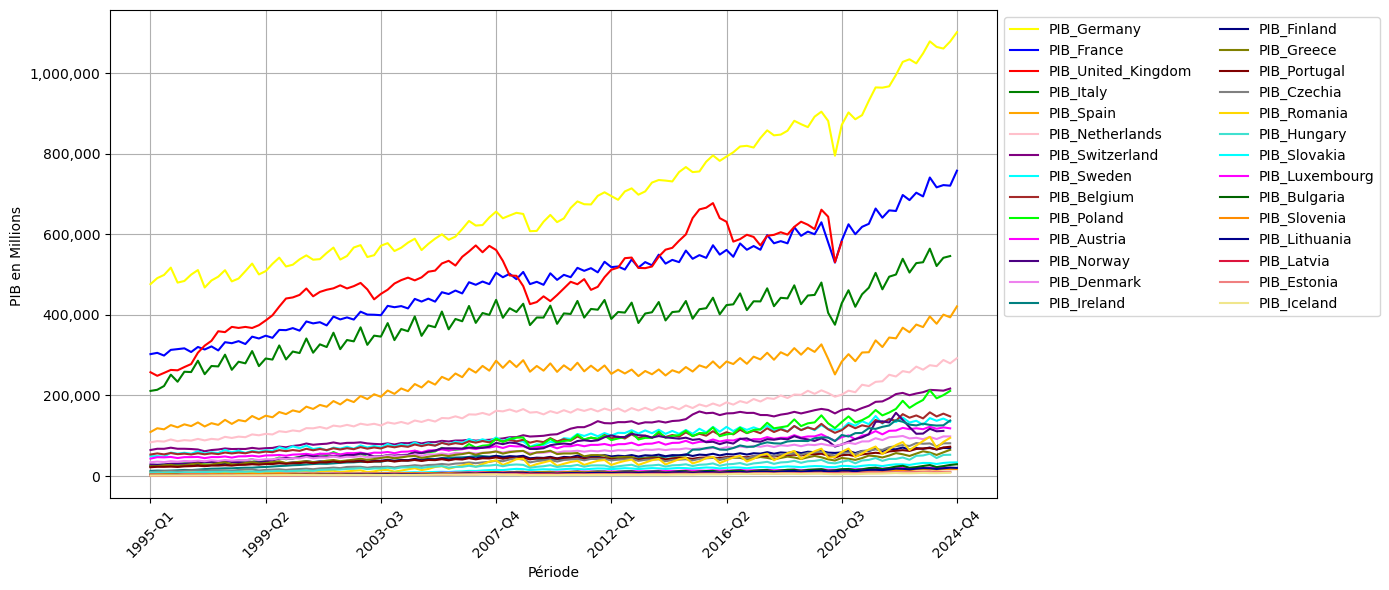

In [5]:
tracer_evolution(PIB, xlabel ="Période",ylabel = "PIB en Millions ")

On voit trois choses sur ce graphiques, d'abord qu'un grand nombre de valeurs sont écrasées par les plus grosses et donc sont difficiles à observer lorsque nous sommes en échelle linéaire, ensuite les séries semblent croissantes et avec des saisons, enfin on distingue bien la période de récession du Covid.

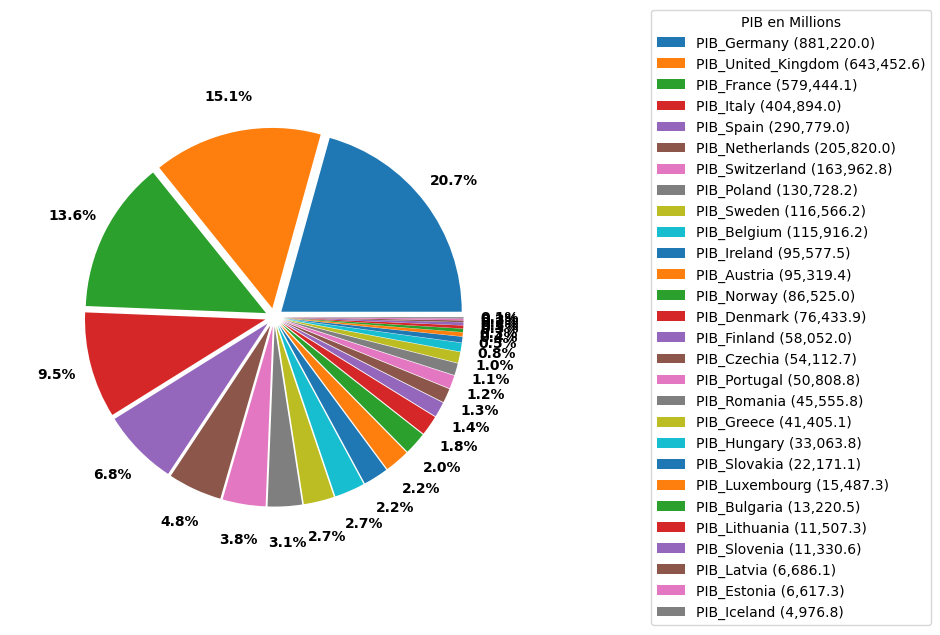

In [21]:
camembert(PIB, période = "2020-Q1", titre = "PIB en Millions")

Ce diagramme fait au premier trimestre de 2020 (dernière date où le PIB du Royaume-Uni est renseignée) illustre parfaitement le fait que les plus gros pays écrase les valeurs des plus petits, en prenant l'Allemagne, le Royaume-Uni, la France, l'Italie et l'Espagne on observe déjà 65% du PIB total, de plus 11 pays comptent pour moins de 1% du total. 

/home/onyxia/work/Stat-App/Codes/scrpits_visualisations.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filtered = df_filtered.applymap(lambda x: np.log(x) if x > 0 else np.nan)


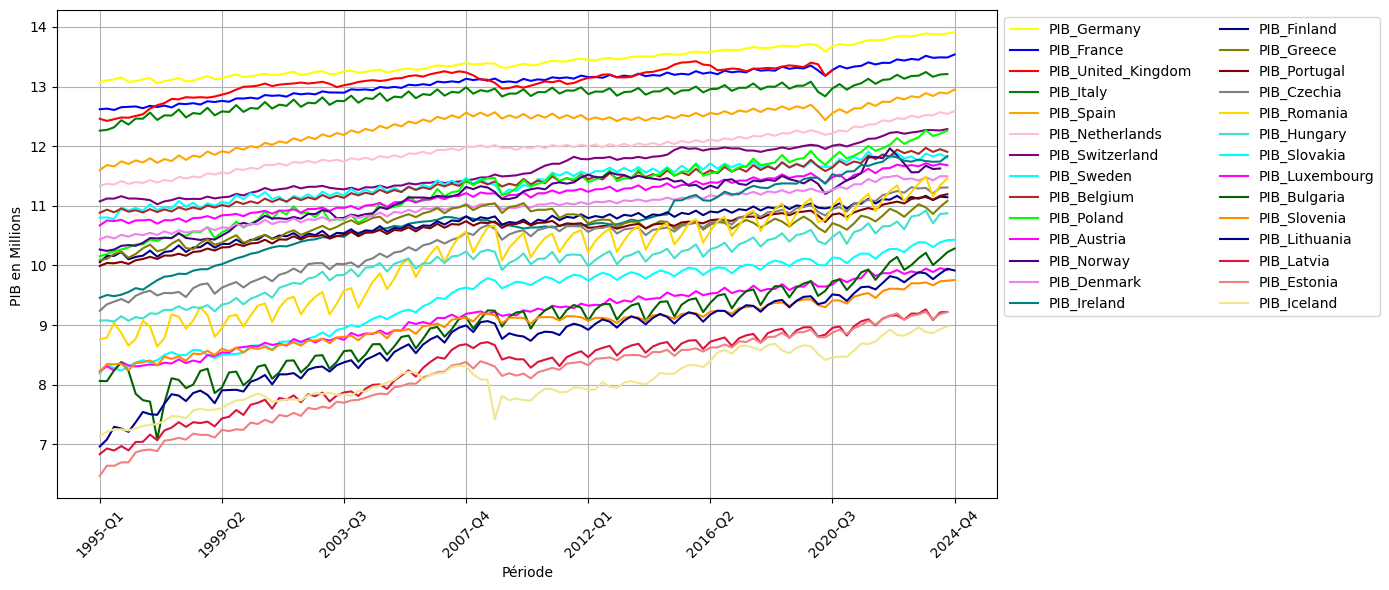

In [ ]:
tracer_evolution(PIB, xlabel ="Période",ylabel = "log(PIB) en Millions ", log = True)

En valeurs logarithmiques on voit bien la tendance linéaire assez similaire entre les séries, tout comme les variations saisonnales. Maintenant on va séparer en deux groupes les PIB afin de pouvoir mieux observer l'effet de la récession du covid. 

In [ ]:
# On sépare en deux groupe selon la valeur de la moyenne
PIB_description = PIB.describe()
PIB_mean_values = PIB_description.loc['mean']
PIB_groupe_1_indices = PIB_mean_values[PIB_mean_values > 200000].index  
PIB_groupe_2_indices = PIB_mean_values[PIB_mean_values < 200000].index
PIB_groupe_1 = PIB[PIB_groupe_1_indices]
PIB_groupe_2 = PIB[PIB_groupe_2_indices]

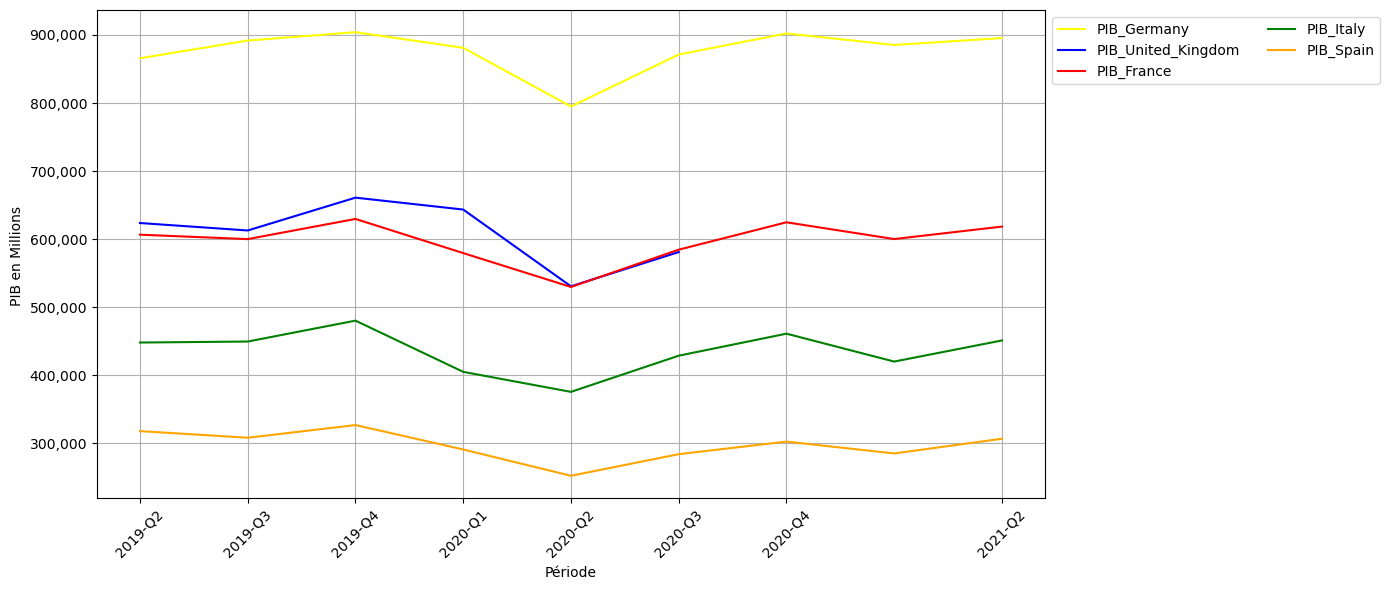

In [10]:
tracer_evolution(PIB_groupe_1, xlabel ="Période",  start_date="2019-Q2", end_date="2021-Q2", ylabel = "PIB en Millions ")

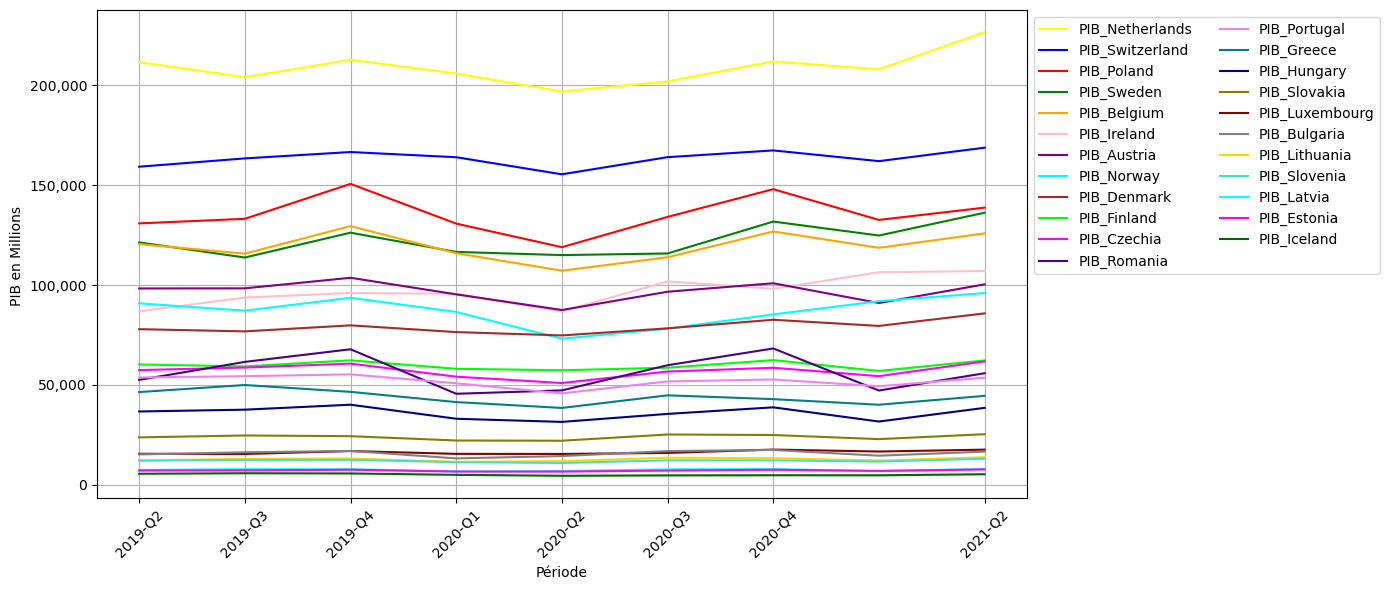

In [11]:
tracer_evolution(PIB_groupe_2, xlabel ="Période",  start_date="2019-Q2", end_date="2021-Q2", ylabel = "PIB en Millions ")

En séparant en deux groupes on constate moins la diminution due au Covid au Q2 de 2020 parmi le groupe dont le PIB moyen est en dessous de 200 Milliards.

In [16]:
comparer_periodes(PIB, "2020-Q1", "2020-Q2")

,Période 1,Période 2,Différence de %
PIB_Austria,95319.4,87490.9,-8.212914
PIB_Belgium,115916.2,107165.4,-7.549247
PIB_Bulgaria,13220.5,14378.1,8.756098
PIB_Czechia,54112.7,50948.8,-5.846871
PIB_Denmark,76433.9,74767.7,-2.179923
PIB_Estonia,6617.3,6598.4,-0.285615
PIB_Finland,58052.0,57324.0,-1.254048
PIB_France,579444.1,529658.3,-8.591994
PIB_Germany,881220.0,794870.0,-9.798915
PIB_Greece,41405.1,38471.8,-7.084393


In [19]:
print(comparer_periodes(PIB, "2020-Q1", "2020-Q2")['Différence de %'].mean())

-5.117752036363803


En observant la différence entre les deux premiers trimestres de 2020 on observe très bien la récession du confinement. La récession moyenne est de -5.12%.

Pour revenir à la séparation des groupes faites lors de l'analyse du CPI, on remarque que tous les pays du groupes 2 précédent sont encore dans le groupe 2 en terme de PIB et que certains pays du groupe 1 sont maintenant dans ce groupe, ce sont surtout les pays d'Europe Centrale et du Nord ayant des populations plus faibles. On pourrait donc être amené à distinguer par la suite trois groupes, les économies qui en train de se développer, les petites économies développées et les grandes économies développées. 

In [ ]:
print(PIB_groupe_2_indices, CPI_groupe_2_indices)

Index(['PIB_Austria', 'PIB_Belgium', 'PIB_Bulgaria', 'PIB_Czechia',
       'PIB_Denmark', 'PIB_Estonia', 'PIB_Finland', 'PIB_Greece',
       'PIB_Hungary', 'PIB_Iceland', 'PIB_Ireland', 'PIB_Latvia',
       'PIB_Lithuania', 'PIB_Luxembourg', 'PIB_Netherlands', 'PIB_Norway',
       'PIB_Poland', 'PIB_Portugal', 'PIB_Romania', 'PIB_Slovakia',
       'PIB_Slovenia', 'PIB_Sweden', 'PIB_Switzerland'],
      dtype='object') Index(['CPI_Bulgaria', 'CPI_Czechia', 'CPI_Estonia', 'CPI_Hungary',
       'CPI_Iceland', 'CPI_Latvia', 'CPI_Lithuania', 'CPI_Poland',
       'CPI_Romania', 'CPI_Slovakia', 'CPI_Slovenia'],
      dtype='object')


##### Taux d'intérêts <a class="anchor" id="partie2311"></a>

In [5]:
colonnes_LT = [colonne for colonne in df_TS.columns if colonne.startswith('LT')]
LT = df[colonnes_LT]
LT.describe()

,LT_IR_Austria,LT_IR_Belgium,LT_IR_Bulgaria,LT_IR_Czechia,LT_IR_Denmark,LT_IR_Estonia,LT_IR_Finland,LT_IR_France,LT_IR_Germany,LT_IR_Greece,...,LT_IR_Norway,LT_IR_Poland,LT_IR_Portugal,LT_IR_Romania,LT_IR_Slovakia,LT_IR_Slovenia,LT_IR_Spain,LT_IR_Sweden,LT_IR_Switzerland,LT_IR_United_Kingdom
count,120.000000,120.000000,88.000000,99.000000,120.000000,18.000000,120.000000,120.000000,120.000000,110.000000,...,120.000000,96.000000,120.000000,79.000000,97.000000,91.000000,120.000000,120.000000,120.000000,120.000000
mean,3.146303,3.286417,3.500985,3.305073,3.108289,2.170741,3.178305,3.165961,2.830254,6.364394,...,3.805418,4.943912,4.572667,5.884494,3.282994,3.339985,3.958722,3.270705,1.785481,3.757386
std,2.029545,2.032646,2.056659,1.728455,2.281636,1.752985,2.227170,1.987021,2.092555,4.572442,...,1.857008,2.052522,2.788568,1.830615,2.244952,2.182669,2.354879,2.445675,1.570003,2.036608
min,-0.410600,-0.370000,0.140000,0.301695,-0.492667,-0.133333,-0.396667,-0.320000,-0.613512,0.696667,...,0.606667,1.250000,0.093333,2.776667,-0.421858,-0.180000,0.100000,-0.166367,-0.776333,0.251367
25%,1.242808,1.340834,1.802500,1.791774,1.072000,0.135833,1.150833,1.355658,0.922880,3.985833,...,2.020000,3.289242,3.070000,4.313333,0.984319,1.213333,2.104167,1.357500,0.415833,1.980817
50%,3.432484,3.673333,3.696667,3.714909,3.267333,3.043334,3.355000,3.434900,3.155577,4.998334,...,3.743334,5.348333,4.216667,6.446667,3.749246,3.750000,4.098333,3.130000,1.952500,4.102700
75%,4.545233,4.576666,5.137500,4.534434,4.518333,3.694167,4.506667,4.477183,4.333534,7.796667,...,5.329167,5.991667,5.467500,7.140833,4.751825,4.708666,5.139167,4.690834,3.020833,4.919459
max,7.627367,8.293333,7.593333,7.442648,8.960000,4.163333,10.213330,8.088200,7.432434,26.003330,...,8.046667,11.713330,13.223330,11.306670,8.330000,9.310000,11.906670,10.963330,5.275333,8.661467


In [6]:
colonnes_ST = [colonne for colonne in df_TS.columns if colonne.startswith('ST')]
ST = df[colonnes_ST]
ST.describe()

,ST_IR_Austria,ST_IR_Belgium,ST_IR_Bulgaria,ST_IR_Czechia,ST_IR_Denmark,ST_IR_Estonia,ST_IR_Finland,ST_IR_France,ST_IR_Germany,ST_IR_Greece,...,ST_IR_Norway,ST_IR_Poland,ST_IR_Portugal,ST_IR_Romania,ST_IR_Slovakia,ST_IR_Slovenia,ST_IR_Spain,ST_IR_Sweden,ST_IR_Switzerland,ST_IR_United_Kingdom
count,120.000000,120.000000,83.000000,120.000000,120.000000,116.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,117.000000,116.000000,92.000000,120.000000,120.000000,102.000000,120.000000
mean,1.936789,1.935289,2.512472,4.052741,2.229275,3.126720,1.974622,2.019914,1.925650,3.696374,...,3.385382,7.802582,2.342233,21.243959,3.991954,1.978703,2.317639,2.149373,0.462934,3.250136
std,1.824380,1.831535,2.219372,4.270747,2.022472,3.605726,1.894259,1.969604,1.814950,4.903212,...,2.137682,7.466291,2.539213,29.604253,5.222604,2.515926,2.488101,2.248216,1.169639,2.532037
min,-0.566377,-0.566377,0.002833,0.280000,-0.422810,-0.566377,-0.566377,-0.566377,-0.566377,-0.566377,...,0.246667,0.210000,-0.566377,0.763333,-0.566377,-0.566377,-0.566377,-0.776667,-0.898711,0.040000
25%,0.072607,0.072607,0.273917,1.113934,0.171664,0.032881,0.072607,0.072607,0.072607,0.072607,...,1.666041,2.633333,0.072607,3.100000,0.032881,-0.298761,0.072607,0.143333,-0.699988,0.621613
50%,2.127494,2.127494,1.915267,2.351882,2.197433,2.480000,2.127494,2.127494,2.127494,2.127494,...,2.706666,4.995783,2.127494,7.263333,2.635963,0.872057,2.127494,1.943334,0.113354,3.959275
75%,3.488333,3.468677,4.335667,5.389143,3.823063,5.328333,3.515579,3.553495,3.462010,4.485126,...,5.073333,8.576666,3.846147,22.386670,5.947500,3.969759,3.846147,3.887500,1.222661,5.518449
max,5.043334,5.706666,7.448367,19.670380,6.854634,18.090000,6.053333,7.482500,5.110000,18.116840,...,8.040000,29.710000,10.527000,126.493300,23.390000,8.633333,9.543667,9.110000,3.315616,7.667380


Les valeurs renseignées pour les taux d'intérêts de long-termes sont assez hétérogènes. 16 pays ont toutes les valeurs de renseignées, les autres pays ont entre 91 et 110 valeurs renseignée sauf la Roumanie avec 79, la Bulgarie avec 88 et l'Estonie avec seulement 18. Concernant les taux à court-terme on a cette fois 19 pays avec toutes les valeurs renseignées et pour les autres on a seulement la Slovénie (avec 92 valeurs) et la Bulgarie (avec 83 valeurs) sous les 100 valeurs renseignée. 

Les moyennes des taux de long terme oscille entre 1,78% pour la Suisse et 7,20% pour l'Islande, avec une majorité des pays au alentour des 3-4%. (21 pays), il y a l'Estonie à 2,1 % et le reste au alentour des 5-6%. Les écart-types sont relativement proches des 2 sauf pour la Grèce avec 4,5, la Lettonie avec 3,9 et la Lituanie avec 3,6.

Pour les taux de court terme les moyennes sont aux environs des 2% pour la plupart des pays des pays d'Europe de l'Ouest et du Nord, et sont plus hautes en moyenne pour les pays d'Europe de l'Est avec notamment la Roumanie et ses 21% de moyenne, la Hongrie avec ses 8,8% et la Pologne avec ses 7,8%. les écart-types sont relativement proches des valeurs moyennes.

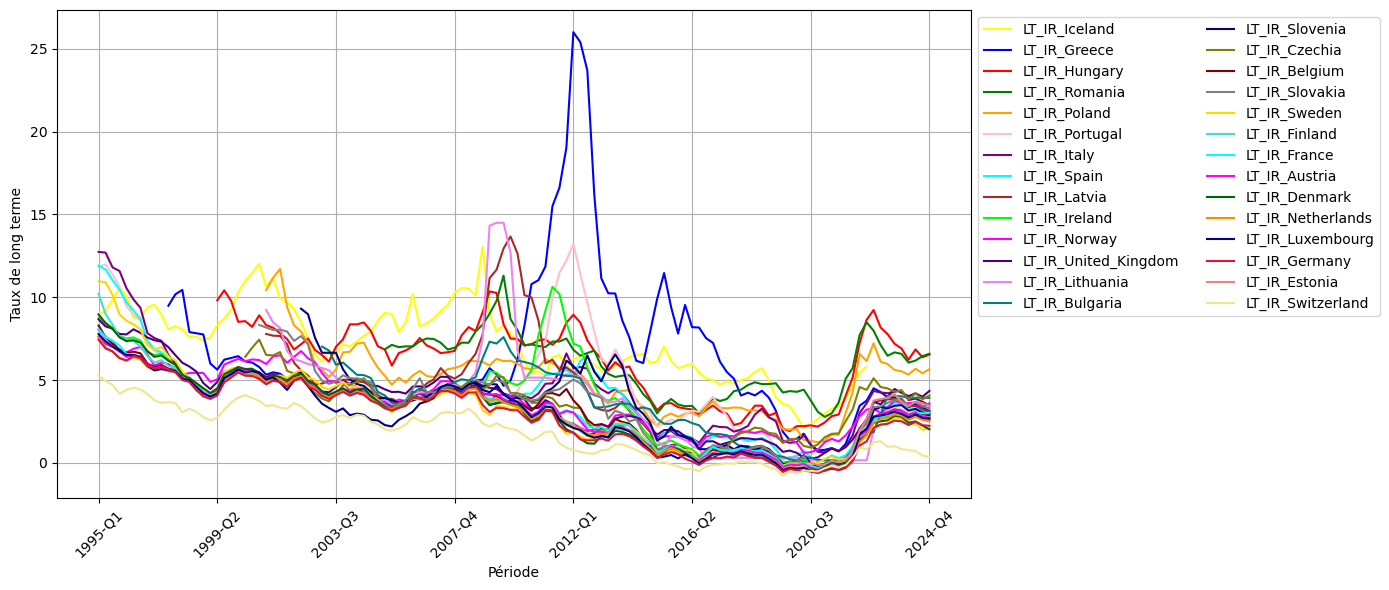

In [ ]:
tracer_evolution(LT, xlabel ="Période", ylabel = "Taux de long terme")

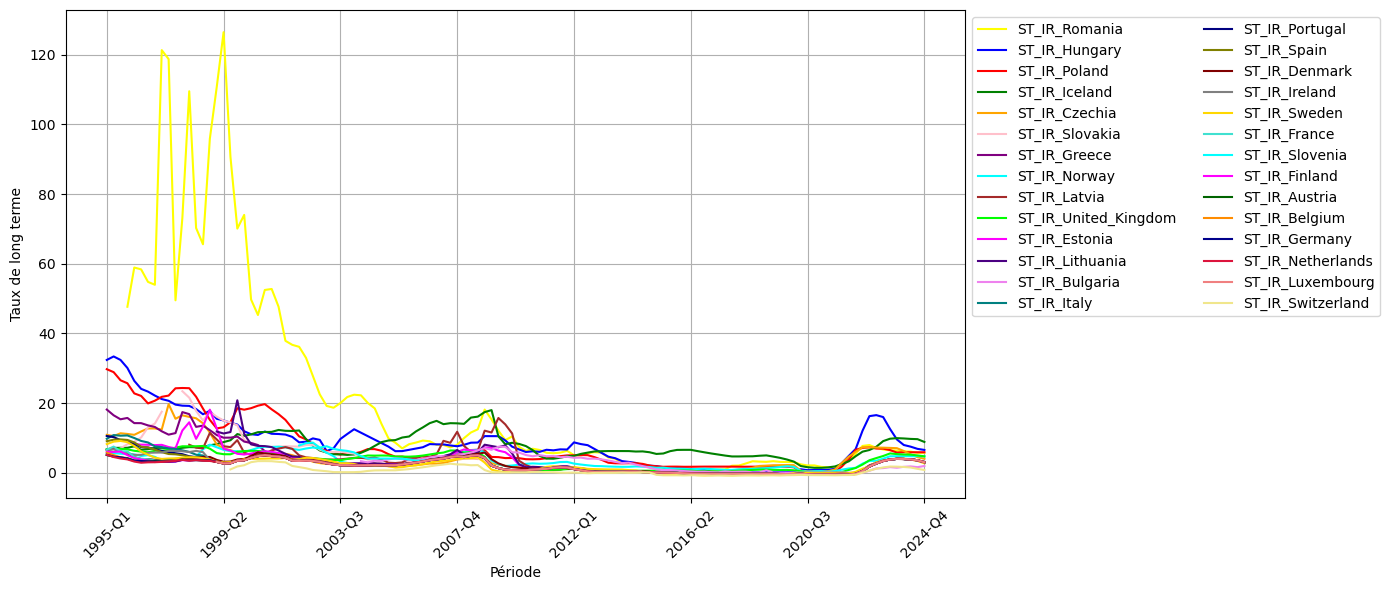

In [ ]:
tracer_evolution(ST, xlabel ="Période", ylabel = "Taux de court terme")

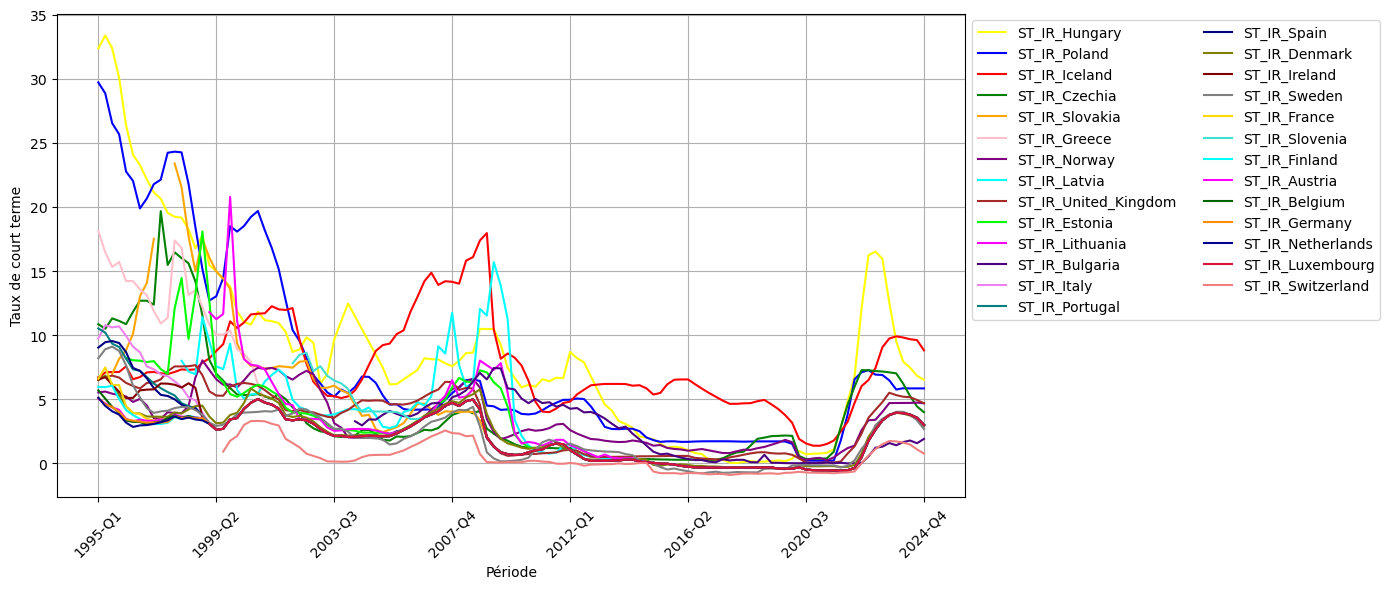

In [40]:
ST_wo_Roumania = ST.drop(columns = ["ST_IR_Romania"])
tracer_evolution(ST_wo_Roumania, xlabel ="Période", ylabel = "Taux de court terme")

On sort la Roumanie de la représentation des taux de court-terme car ses valeurs sont trop grandes. Pour les taux de long-terme on observe une corrélation entre les taux assez forte avec une tendance décroissante marquée par deux bosses en 2008 et 2012 qui correspondent à la crise des subprimes et de l'euro, puis une troisième en 2022 qui est celle qui nous intéresse pour cette étude. Concernant les taux de court-terme on a des fortes irrégularités jusqu'en 2003, puis une période de stabilisation avant une hausse en 2008 et une autre périodes stable jusqu'à la hausse de 2022.

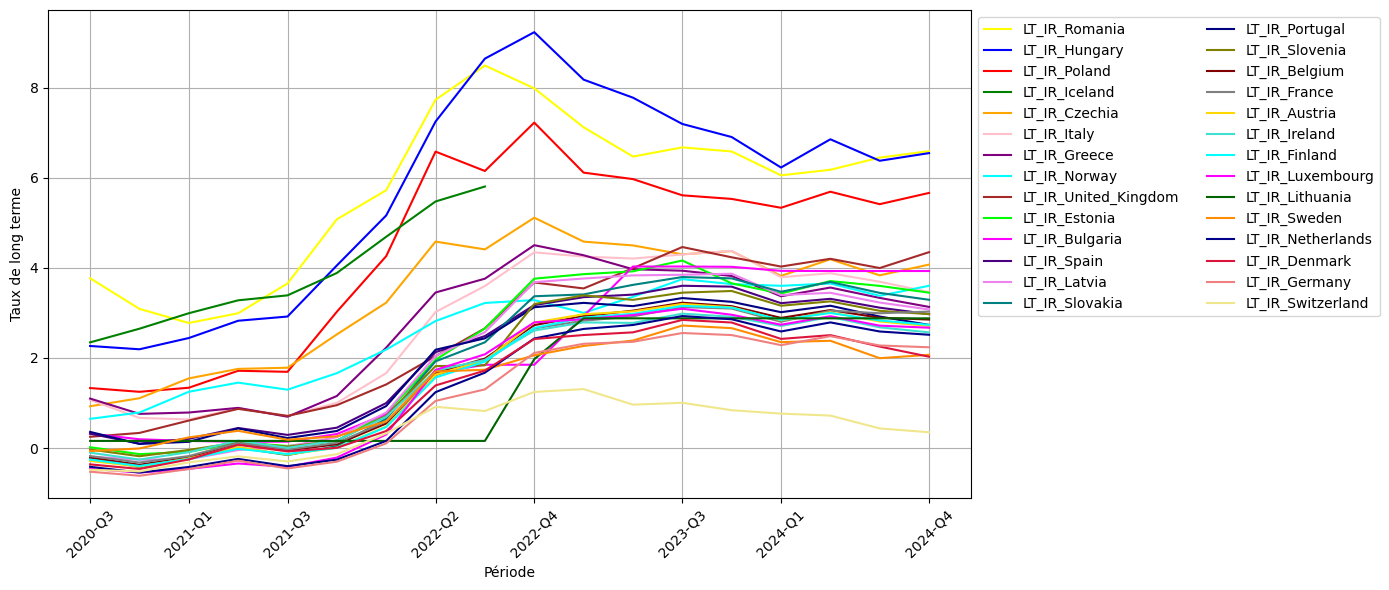

In [41]:
tracer_evolution(LT, xlabel ="Période", start_date="2020-Q3", end_date="2024-Q4",ylabel = "Taux de long terme")

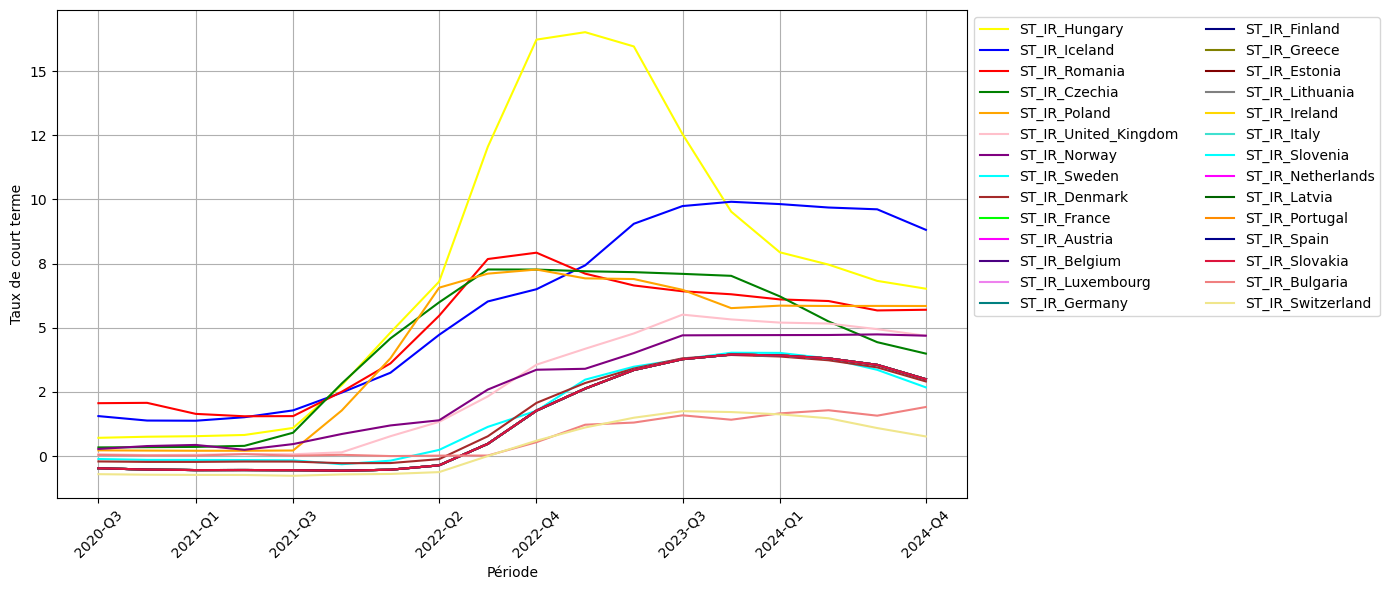

In [42]:
tracer_evolution(ST, xlabel ="Période", start_date="2020-Q3", end_date="2024-Q4",ylabel = "Taux de court terme")

En regardant plus précisément les périodes qui nous intéressent, on remarque que la hausse débute dès le Q3 de 2021 et semble se stabiliser à partir du Q3 de 2023.

In [7]:
comparer_periodes(LT, "2020-Q3", "2023-Q3", percent = False)

NameError: name 'pd' is not defined

#### Étude des corrélations <a class="anchor" id="partie222"></a>

Correlations\
Idée: nous allons étudier les correlations entre plusieurs variables de 4 pays (corrélations à l'intérieur du même pays)

In [ ]:
France=variables_pays('France')
Germany=variables_pays('Germany')
Denmark=variables_pays('Denmark')
Romania=variables_pays('Romania')

plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
sns.heatmap(df[France].corr())
plt.title("Matrice de corrélation des variables de la France")

plt.subplot(2,2,2)
sns.heatmap(df[Germany].corr())
plt.title("Matrice de corrélation des variables de l'Allemagne")

plt.subplot(2,2,3)
sns.heatmap(df[Denmark].corr())
plt.title("Matrice de corrélation des variables du Danemark")

plt.subplot(2,2,4)
sns.heatmap(df[Romania].corr())
plt.title("Matrice de corrélation des variables de la Roumanie")



### Une première analyse exploratoire des séries temporelles <a class="anchor" id="partie24"></a>

Pour chaque variable, nous allons déterminer  le tendances et les saisonalités des séries temporelles. Compte tenu du nombre de pays dans notre échantillon, nous allons tout d'abord faire cette analyse pour la France et pour les principaux pays d'Europe. 

#### Données du PIB <a class="anchor" id="partie241"></a>

In [ ]:
#Fonction qui effectue la représentation de l'évolution du PIB d'un seul pays. 

def graphe_PIB(pays): 
    plt.figure(figsize=(14, 6))  # Taille du graphique

    plt.plot(df_TS.index, df_TS[f'PIB_{pays}'], marker='o', linestyle='-')

    plt.xlabel("Période")
    plt.ylabel("PIB en millions")
    plt.title(f"Évolution du PIB - {pays} (1995-2024)")

    #   Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
    num_ticks = 8  # Nombre de labels affichés sur l'axe X
    indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
    plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

    plt.grid(True)
    return(plt.show())


In [ ]:
#Représentation graphique de plusieurs pays
selected_countries = ['Austria', 'France', 'United_Kingdom','Spain', 'Italy', 'Netherlands', 'Switzerland'] #Ici pon peut choisir les pays que l'on veut
df_selected = df.loc[:,[f'PIB_{pays}' for pays in selected_countries]]

def PIB_Groupes(group)
colors = plt.cm.get_cmap("tab10", len(df_selected.columns))  # Utilisation d'une palette de couleurs
plt.figure(figsize=(14, 6))

for i, country in enumerate(df_selected.columns): #enumerate permet de sélectionner l'élément et son indice
    plt.plot(df_selected.index, df_selected[country], label=country, color=colors(i))

# Personnalisation du graphique
plt.xlabel("Période")
plt.ylabel("PIB en Millions")
plt.title("Principaux PIB trimestriels en Europe ")

# Indicage
num_ticks = 8 
indices = np.linspace(0, len(df_selected.index) - 1, num_ticks, dtype=int)  
plt.xticks(df_selected.index[indices], rotation=45) 

# Affichage 
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)  # Légende en dehors du graphique
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) #permet de ne pas avoir d'écriture scientifique
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['PIB_France'].resample('Q').mean())
plt.show()

A première vue, il semblerait qu'il n'y ait pas de saisonalité pour le PIB

Ce qui suit est un brouillon qui nous sera utile lorsque nous aurons déterminé la stationnarité de la série temporelle

In [ ]:
#Autocorrélation (ACF)
plt.figure(figsize=(14,6))
tsaplots.plot_acf(df_TS['PIB_France'], lags=30)
plt.title("Fonction d'autocorrélation du PIB de la France")
plt.show()

#Remarque: on n'a pas encore vérifié que la série est stationnaire, donc l'intévalle de confiance peut-être biaisé


In [ ]:
#Autocorrélation partielle (PACF)
plt.figure(figsize=(14,6))
tsaplots.plot_pacf(df_TS['PIB_France'], lags=30)
plt.title("Fonction d'autocorrélation partielle du PIB de la France")
plt.show()

#### Données des Working Hours <a class="anchor" id="partie242"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['WH_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Nombre d'heures travaillées par semaine")
plt.title("Évolution du nombre d'heures travaillées en France(1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

La tendance décroissance du nombre d'heures travaillées en France peut s'expliquer par
- l'interpolation faite entre 1995-2002 (données annuelles disponibles uniquement)
- la mise en place des lois (nombre d'heures qui passe de 39 à 35)

#### Données des taux d'intérêt à long terme <a class="anchor" id="partie243"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['LT_IR_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Taux d'intérêt (Long Terme) de la France")
plt.title("Évolution du taux d'intérêt (long terme) de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['LT_IR_France'].resample('Q').mean())
plt.show()

#### Données des taux d'intérêt à court terme <a class="anchor" id="partie244"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['ST_IR_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Taux d'intérêt (court terme)")
plt.title("Évolution du taux d'intérêt (court terme) de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['ST_IR_France'].resample('Q').mean())
plt.show()

#### Données du CPI <a class="anchor" id="partie245"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['PIB_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("CPI")
plt.title("Évolution du du CPI de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

In [ ]:
#Représentation de la saisonalité
plt.figure()
tsaplots.quarter_plot(df_TS['PIB_France'].resample('Q').mean())
plt.show()

#### Données de la croissance potentielle <a class="anchor" id="partie246"></a>

In [ ]:
#Représentation graphique
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df_TS.index, df_TS['P_Growth_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Croissance potentielle")
plt.title("Évolution de la croissance potentielle de la France (1995-2021)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df_TS.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df_TS.index[indices],df_TS.index[indices].to_period('Q').strftime('%Y-Q%q'),rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

## Visualisation <a class="anchor" id="partie3"></a>

### Données de PIB <a class="anchor" id="partie31"></a>

Pour notre rendu de mi-parcours nous avons présenté les évolutions des PIB en France et dans les principaux pays d'Europe. Nous faisons d'abord celui de la France.

In [ ]:
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df.index, df['PIB_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("PIB de la France")
plt.title("Évolution du PIB de la France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 8  # Nombre de labels affichés sur l'axe X
indices = np.linspace(0, len(df.index) - 1, num_ticks, dtype=int)  # Espacement des indices
plt.xticks(df.index[indices],rotation=45)  # Appliquer les labels espacés

plt.grid(True)
plt.show()

Et ensuite pour l'Europe

In [ ]:
selected_countries = ['PIB_Germany', 'PIB_France', 'PIB_United_Kingdom','PIB_Spain', 'PIB_Italy', 'PIB_Netherlands', 'PIB_Switzerland']

df_selected = df[selected_countries]

colors = plt.cm.get_cmap("tab10", len(df_selected.columns))  # Utilisation d'une palette de couleurs
plt.figure(figsize=(14, 6))

for i, country in enumerate(df_selected.columns): #enumerate permet de sélectionner l'élément et son indice
    plt.plot(df_selected.index, df_selected[country], label=country, color=colors(i))

# Personnalisation du graphique
plt.xlabel("Période")
plt.ylabel("PIB en Millions")
plt.title("Principaux PIB trimestriels en Europe ")

# Indicage
num_ticks = 8 
indices = np.linspace(0, len(df_selected.index) - 1, num_ticks, dtype=int)  
plt.xticks(df_selected.index[indices], rotation=45) 

# Affichage 
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=2)  # Légende en dehors du graphique
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) #permet de ne pas avoir d'écriture scientifique
plt.show()


### Données d'heures travaillées <a class="anchor" id="partie32"></a>

Voici l'évolution des heures travaillées en France.

In [ ]:
plt.figure(figsize=(14, 6))  # Taille du graphique

plt.plot(df.index, df['WH_France'], marker='o', linestyle='-')

plt.xlabel("Période")
plt.ylabel("Heures travaillées en France")
plt.title("Évolution des heures travaillées en France (1995-2024)")

# Sélectionner un sous-ensemble des labels de l'axe X pour éviter la surcharge
num_ticks = 10 
indices = np.linspace(0, len(df.index) - 1, num_ticks, dtype=int)
plt.xticks(df.index[indices], rotation=45)
plt.grid(True)
plt.show()